# Explore Natural vs. Anthropogenic CO$_{2}$
- After ICDC, we realized that it isn't exactly clear what our residuals represent. For awhile, we portrayed them as simply "natural CO$_{2}$." We realized recently, that embedded in the ensemble mean (forced signal) is a strong seasonal cycle. The trend within the ensemble mean is likely the anthropogenic invasion of carbon, but what is this seasonal cycle? Surely it isn't purely anthropogenic carbon, so these residuals more likely represent variability in natural CO2 due to internally generated variability. 
- The goal of this notebook is to use FG_ALT_CO2 output to understand what all of our time series components represent. The same processing has been done to the FG_ALT_CO2 output as other variables: it has been area-weighted over each region and split into the ensemble mean and residuals. The output itself was generated with the same dynamics of each run but with constant pre-industrial CO2 levels. Thus, it represents purely natural CO2 flux. We can take FG_CO2 - FG_ALT_CO2 to accurately extract anthropogenic carbon.
- The questions we are trying to answer here are:

1. What do the residuals represent from the FG_CO2 runs?
2. Is there any trend in the FG_ALT_CO2 timeseries?
3. Does the seasonal cycle show up in the FG_ALT_CO2 output? What drives that seasonal cycle?

Once we answer these fundamental questions, we can go on to really quantify and characterize the full time series from the historical runs.

In [75]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

# Set Parameters

In [76]:
EBU = "CalCS"

# Functions

In [77]:
def load_in_filtered_data(VAR, EBU, AW=True):
    fileDir = '/glade/p/work/rbrady/EBUS_BGC_Variability/' + VAR + '/' + EBU + '/filtered_output/'
    if AW == True:
        ds_forced = xr.open_dataset(fileDir + EBU.lower() + '-' + VAR + '-forced-signal-AW-chavez-800km.nc')
        ds_residuals = xr.open_dataset(fileDir + EBU.lower() + '-' + VAR + '-residuals-AW-chavez-800km.nc')
    if AW == False:
        ds_forced = xr.open_dataset(fileDir + EBU.lower() + '-' + VAR + '-forced-signal-chavez-800km.nc')
        ds_residuals = xr.open_dataset(fileDir + EBU.lower() + '-' + VAR + '-residuals-chavez-800km.nc')
    ds_total = ds_forced + ds_residuals
    return ds_forced, ds_residuals, ds_total

# Load in FG_ALT_CO2 and FG_CO2 Output

In [78]:
alt_forced, alt_residuals, alt_total = load_in_filtered_data('FG_ALT_CO2', EBU)
contemp_forced, contemp_residuals, contemp_total = load_in_filtered_data('FG_CO2', EBU)

# (1) Does the seasonal cycle show up in FG_ALT_CO2?
We are interested in how much of this seasonal cycle in the contemporary FG_CO2 is due to natural carbon fluxes.

In [81]:
# Pull out the ensemble mean from both variables (which should be the seasonal cycle + trend)
contemp_seasonal = contemp_forced['FG_CO2_AW'].values
natural_seasonal = alt_forced['FG_ALT_CO2_AW'].values

# Pull out the time component for plotting
t = alt_forced['time'].values

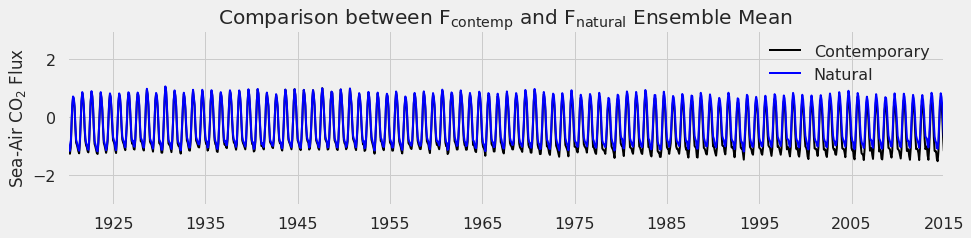

In [88]:
fig = plt.figure(figsize=(14,3))
ax = plt.subplot(111)
plt.plot(t, contemp_seasonal, color='k', linewidth=2, label='Contemporary')
plt.plot(t, natural_seasonal, color='b', linewidth=2, label='Natural')

ax.set_title('Comparison between F$_{\mathrm{contemp}}$ and F$_{\mathrm{natural}}$ Ensemble Mean')
ax.set_ylabel('Sea-Air CO$_{2}$ Flux')
ax.set(ylim=[-3, 3], xlim=['1920', '2015'])
legend = ax.legend(loc='upper right')

At first glance, the seasonal cycles look quite similar. It seems as though the deviation is due to a trend in the contemporary CO$_{2}$ flux cycle. To test this hypothesis, I will remove a 4th order polynomial fit (seems to be standard in climate literature, such as Hawkins papers and Deser papers) and then correlate the two time series to see how much of the variability is explained. We can probably assume that any residual is due to a seasonal cycle from anthropogenic CO$_{2}$.

In [125]:
import numpy.polynomial.polynomial as poly
def remove_polynomial_fit(data, order=4):
    x = np.arange(0, len(data), 1)
    coefs = poly.polyfit(x, data, order)
    line_fit = poly.polyval(x, coefs)
    return (data - line_fit), coefs

In [126]:
# Remove 4th order polynomial from each time series and re-plot.
detrended_contemp, contemp_coefs = remove_polynomial_fit(contemp_seasonal)
detrended_natural, nat_coefs = remove_polynomial_fit(natural_seasonal)

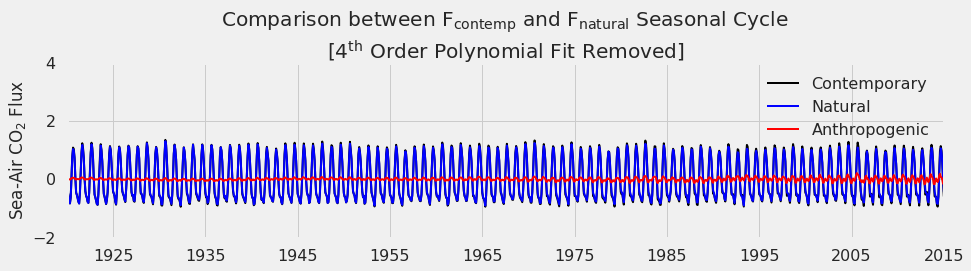

In [154]:
fig = plt.figure(figsize=(14,3))
ax = plt.subplot(111)
plt.plot(t, detrended_contemp, color='k', linewidth=2, label='Contemporary')
plt.plot(t, detrended_natural, color='b', linewidth=2, label='Natural')
plt.plot(t, (detrended_contemp - detrended_natural), color='r', linewidth=2, label='Anthropogenic')

ax.set_title('Comparison between F$_{\mathrm{contemp}}$ and F$_{\mathrm{natural}}$ Seasonal Cycles' + '\n' +
             '[4$^{\mathrm{th}}$ Order Polynomial Fit Removed]')
ax.set_ylabel('Sea-Air CO$_{2}$ Flux')
ax.set(ylim=[-2, 4], xlim=['1920', '2015'])
legend = ax.legend(loc='upper right')

After removing a 4th order polynomial, these time series look a lot more similar. Interestingly, the detrended anthropogenic seasonal cycle becomes larger over time. **A potential area to explore for each system is if the natural component of the seasonal cycle maintains a constant amplitude, but the total (contemporary) seasonal cycle grows in amplitude due to this anthropogenic invasion**.

Before comparing the trends themselves, let's correlate these detrended seasonal cycles. I'll simply run a correlation between the detrended time series and look at what comes out.

In [152]:
from scipy import stats
slope, intercept, r, p, std_err = stats.linregress(detrended_natural, detrended_contemp)
print('Slope     : ' + str(slope))
print('R         : ' + str(r))
print('R Squared : ' + str(r**2))
print('p         : ' + str(p))

Slope     : 1.05156484925
R         : 0.998170559957
R Squared : 0.996344466765
p         : 0.0


### Question: 
Does the seasonal cycle show up in FG_ALT_CO2?

### Answer:
Yes. It seems that the FG_CO2 ensemble mean periodic component is driven by the seasonal cycle of natural CO$_{2}$. After detrending the contemporary (FG_CO2) and natural (FG_ALT_CO2) time series ensemble means, we find that 99.6% of the variability of the contemporary time series is explained by the natural time series. The interesting thing is that it seems as though the total amplitude might slightly grow, and it could be driven by the anthropogenic perturbation. This is something that can be explored further for each system.